# Covariate selection

Date: 16 October 2025<br>
By: Eunhye Yang<br>
Description:<br>
Using two methods to identify covariates<br>
1. Correlation analysis
2. Random Forest Regressor

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import kstest, mannwhitneyu, chi2_contingency
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

nosurgery = pd.read_csv('preprocessing/imputed_nosurgery_thesis.csv')
surgery = pd.read_csv('preprocessing/imputed_surgery_thesis.csv')

## Clean up dataframe

In [2]:
surgery = surgery.drop(['@6MmRS', '@6Mmortality'], axis=1)
nosurgery = nosurgery.drop(['@6MmRS', '@6Mmortality', 'ICHScore', 'mICHScore'], axis=1)

# surgery vs no surgery
nosurgery['operation'] = 0
surgery = surgery.rename(columns={'TypeOfOT (1=clot evacuation, 2=EVD only)' : 'operation'})

In [3]:
continuous = ['Age', 'AdmissionsystolicBP', 'AdmissiondiastolicBP', 'Admissionpulserate', 'LARGESTICHVOLUME']
ordinal = ['AdmissionGCS', 'Esubscore', 'Vsubscore', 'Msubscore', 'ULpower', 'LLpower', 'CKDclass', 'GRAEBSCORE']
categorical = [i for i in nosurgery.columns if i not in continuous and i not in ordinal and i != 'operation']

## Correlation analysis

### Continuous

In [4]:
for i in continuous:
    p = kstest(surgery[i], nosurgery[i])[1]
    if p < 0.05: print(i + ' (significant)')
    else: print(i)
    print('p-value:', p)

Age (significant)
p-value: 1.6281302746810202e-13
AdmissionsystolicBP (significant)
p-value: 0.00047932586343023764
AdmissiondiastolicBP (significant)
p-value: 0.0002869420092491443
Admissionpulserate
p-value: 0.7622404858854336
LARGESTICHVOLUME (significant)
p-value: 4.81249370140789e-11


### Ordinal

In [5]:
for i in ordinal:
    p = mannwhitneyu(surgery[i], nosurgery[i])[1]
    if p < 0.05: print(i + ' (significant)')
    else: print(i)
    print('p-value:', p)

AdmissionGCS (significant)
p-value: 1.4312184789660265e-15
Esubscore (significant)
p-value: 1.768670129950869e-14
Vsubscore (significant)
p-value: 1.2754500134629634e-13
Msubscore (significant)
p-value: 1.0238485153185666e-08
ULpower (significant)
p-value: 3.394066578711793e-05
LLpower (significant)
p-value: 5.773992576592568e-06
CKDclass (significant)
p-value: 9.912650757341216e-05
GRAEBSCORE (significant)
p-value: 3.7079965812895995e-13


## Categorical

In [6]:
for i in categorical:
    try:
        p = chi2_contingency(
            [np.unique(surgery[i], return_counts=True)[1],
            np.unique(nosurgery[i], return_counts=True)[1]]
        )[1]
    except:
        p = chi2_contingency(
            [np.append(np.unique(surgery[i], return_counts=True)[1], np.array(0)),
            np.unique(nosurgery[i], return_counts=True)[1]]
        )[1]
    if p < 0.05: print(i + ' (significant)')
    else: print(i)
    print('p-value:', p)

Sex0female1male
p-value: 0.39730913662108447
Race0chinese1nonchinese
p-value: 1.0
DM0no1yes
p-value: 0.716496918949511
ISTIA
p-value: 0.2377044568084315
ICH0no1yes
p-value: 0.11477727410220695
Atrialfibirllation
p-value: 0.11319453411638938
Anticoagulant0no1warfarin2NOAC (significant)
p-value: 0.024825803884955925
Statin0no1Simva2Atorva3Rovu4others
p-value: 0.1859247849463124
location0tha1ICGP2LN3caudate4lobar5occipital6brainstem7cerebe (significant)
p-value: 2.1889898174932327e-06
Location0supratentorial1infratentorial
p-value: 0.3973459746301887
Laterality0L1R2Central
p-value: 0.3593183108744598


## Random Forest Regressor

In [7]:
df = pd.concat([surgery, nosurgery])
y = df['operation'].copy()
y[y > 1] = 1
X = df.drop('operation', axis=1).copy()

In [8]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [9]:
params = {
    'n_estimators': np.arange(10, 100, 10),
    'max_depth': np.arange(10, 100, 10)
}
rf = RandomForestRegressor(random_state=42)

rf_cv = GridSearchCV(rf, param_grid=params, cv=kf)
rf_cv.fit(X, y)
print('Best params: ', rf_cv.best_params_)

Best params:  {'max_depth': np.int64(20), 'n_estimators': np.int64(80)}


In [10]:
rf = RandomForestRegressor(n_estimators=80, max_depth=20, random_state=42)
rf.fit(X, y)

,n_estimators,80
,criterion,'squared_error'
,max_depth,20
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


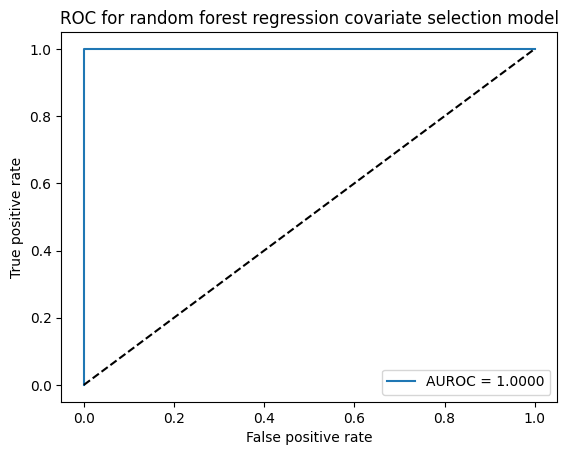

In [11]:
pred = rf.predict(X)
fpr, tpr, _ = roc_curve(y, pred)
auc = roc_auc_score(y, pred)

plt.plot(fpr, tpr, label=f'AUROC = {auc:.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC for random forest regression covariate selection model')
plt.legend(loc='lower right')
plt.show()

In [13]:
features = [rf.feature_names_in_, rf.feature_importances_]

In [14]:
for i in range(len(features[0])):
    highest = features[1][i]
    for j in range(i, len(features[1])):
        if features[1][j] > highest:
            highest = features[1][j]
            temp = features[0][i]
            features[0][i] = features[0][j]
            features[0][j] = temp
            temp = features[1][i]
            features[1][i] = features[1][j]
            features[1][j] = temp

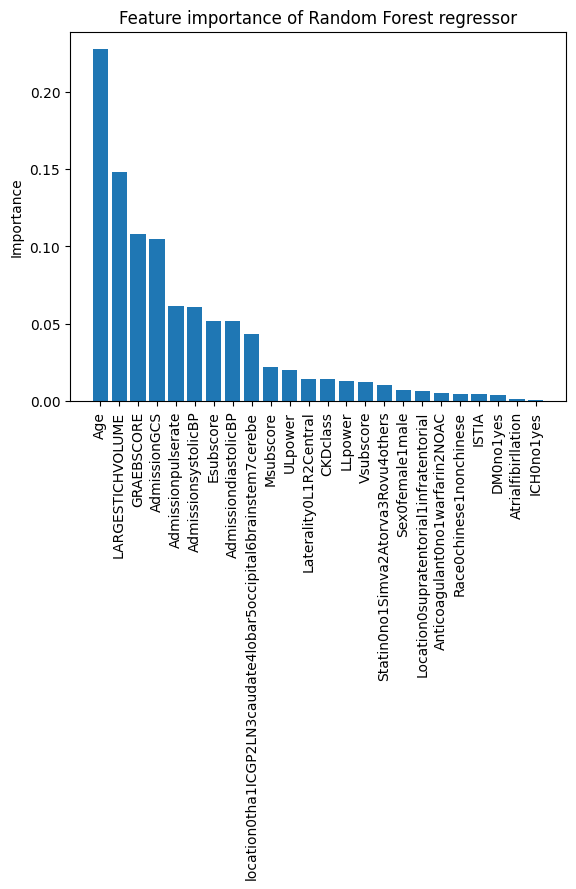

In [15]:
plt.bar(range(len(features[1][:])), features[1][:])
plt.xticks(range(len(features[0][:])), features[0][:], rotation='vertical')
plt.ylabel('Importance')
plt.title('Feature importance of Random Forest regressor')
plt.show()

In [16]:
add = 0
for name, importance in zip(features[0], features[1]):
    add += importance
    if add > 0.9: break
    print(name, ': ', importance)

Age :  0.22721080812817313
LARGESTICHVOLUME :  0.14794346462870006
GRAEBSCORE :  0.10781257287282417
AdmissionGCS :  0.10504232800697924
Admissionpulserate :  0.061347234159925976
AdmissionsystolicBP :  0.061051335124370075
Esubscore :  0.052116074260752376
AdmissiondiastolicBP :  0.05185533506268623
location0tha1ICGP2LN3caudate4lobar5occipital6brainstem7cerebe :  0.04352058865461367
Msubscore :  0.021964905885184644
